In [3]:
import optuna
from optuna.integration.tensorboard import TensorBoardCallback
from optuna.trial import TrialState

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import comma_format, percent_format, currency_format
from datetime import datetime, timedelta, date
from tqdm.notebook import tqdm
from skimpy import clean_columns
from IPython.display import clear_output, display
import holidays

pd.set_option("display.max.columns", 50)

%load_ext blackcellmagic

In [23]:
active_losses = pd.read_csv("../data/Active-Losses-2022_test.csv", index_col=0, parse_dates=["datetime"]).rename(columns={"Wirkverluste/Active Losses": "MWh"})

# active_losses.columns = active_losses.iloc[
#     0,
# ]
# active_losses = (
#     active_losses.drop(active_losses.index[0])
#     .assign(
#         datetime=lambda x: (
#             pd.to_datetime(x["datetime"]) - pd.Timedelta("15 minutes")
#         ).dt.floor(freq="H"),
#         kWh=lambda x: pd.to_numeric(x["kWh"]) / 1000,
#     )
#     .groupby("datetime")
#     .agg(MWh=("kWh", "sum"))
#     .reset_index()
# )
active_losses

,datetime,MWh
0,2022-01-01 00:00:00,146.054792
1,2022-01-01 01:00:00,139.133354
2,2022-01-01 02:00:00,147.562500
3,2022-01-01 03:00:00,157.636204
4,2022-01-01 04:00:00,163.326766
...,...,...
8755,2022-12-31 19:00:00,67.876028
8756,2022-12-31 20:00:00,72.765318
8757,2022-12-31 21:00:00,81.277633
8758,2022-12-31 22:00:00,95.496046


In [14]:
renewables = pd.read_csv(
    "../data/Forecast-renewable-generation_2022_test.csv", parse_dates=["datetime"], index_col=0
).pipe(clean_columns).drop("unnamed_0", axis=1)

renewables

,datetime,solar_fore_de_mw,solar_fore_it_mw,wind_fore_de_mw,wind_fore_it_mw
0,2022-01-01 00:00:00,0.0,0.0,31805.65,1331.48
1,2022-01-01 01:00:00,0.0,0.0,29880.67,1438.15
2,2022-01-01 02:00:00,0.0,0.0,28826.75,1623.80
3,2022-01-01 03:00:00,0.0,0.0,27631.75,1894.75
4,2022-01-01 04:00:00,0.0,0.0,27128.00,2335.05
...,...,...,...,...,...
8755,2022-12-31 19:00:00,0.0,0.0,44107.32,569.68
8756,2022-12-31 20:00:00,0.0,0.0,44512.60,459.45
8757,2022-12-31 21:00:00,0.0,0.0,44946.45,399.35
8758,2022-12-31 22:00:00,0.0,0.0,44938.83,420.78


In [19]:
temperature = pd.read_csv(
    "../data/eq_temp_2022_test.csv.csv", parse_dates=["datetime"], index_col=0
).assign(datetime=lambda x: x["datetime"] - pd.Timedelta("1 hour")).drop("Unnamed: 0", axis=1)

temperature

,datetime,temperature_fore_ch,temperature_fore_fr,temperature_fore_de,temperature_fore_it
0,2021-12-31 23:00:00,6.65,7.90,10.25,7.38
1,2022-01-01 00:00:00,6.77,8.31,10.64,7.25
2,2022-01-01 01:00:00,6.42,8.01,10.46,7.09
3,2022-01-01 02:00:00,6.08,7.77,10.21,6.94
4,2022-01-01 03:00:00,5.68,7.62,10.07,6.85
...,...,...,...,...,...
8755,2022-12-31 18:00:00,10.37,14.18,14.13,11.68
8756,2022-12-31 19:00:00,9.67,13.90,13.91,10.76
8757,2022-12-31 20:00:00,9.10,13.57,13.79,10.06
8758,2022-12-31 21:00:00,8.64,13.29,13.64,9.61


In [21]:
ntc = pd.read_csv("../data/ntc_2022_test.csv", parse_dates=["datetime"], index_col=0).drop("Unnamed: 0", axis=1)
ntc

,datetime,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH
0,2022-01-01 00:00:00,1200.0,4000.0,1400.0,3158.0,1200.0,800.0,3200.0,1910.0
1,2022-01-01 01:00:00,1200.0,4000.0,1400.0,3213.0,1200.0,800.0,3200.0,1910.0
2,2022-01-01 02:00:00,1200.0,4000.0,1400.0,2824.0,1200.0,800.0,3200.0,1910.0
3,2022-01-01 03:00:00,1200.0,4000.0,1400.0,2678.0,1200.0,800.0,3200.0,1910.0
4,2022-01-01 04:00:00,1200.0,4000.0,1400.0,2629.0,1200.0,800.0,3200.0,1910.0
...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,1200.0,4000.0,1200.0,1507.0,1000.0,800.0,3700.0,1810.0
8756,2022-12-31 20:00:00,1200.0,4000.0,1200.0,1507.0,1000.0,800.0,3700.0,1810.0
8757,2022-12-31 21:00:00,1200.0,4000.0,1200.0,1507.0,1000.0,800.0,3700.0,1810.0
8758,2022-12-31 22:00:00,1200.0,4000.0,1200.0,1459.0,1000.0,800.0,3700.0,1810.0


In [26]:
df = (
    active_losses
    .merge(
        temperature, how="left", on="datetime"
    )
    .ffill()
    .merge(renewables, how="left", on="datetime")
    .merge(ntc, how="left", on="datetime")
)

df

,datetime,MWh,temperature_fore_ch,temperature_fore_fr,temperature_fore_de,temperature_fore_it,solar_fore_de_mw,solar_fore_it_mw,wind_fore_de_mw,wind_fore_it_mw,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH
0,2022-01-01 00:00:00,146.054792,6.77,8.31,10.64,7.25,0.0,0.0,31805.65,1331.48,1200.0,4000.0,1400.0,3158.0,1200.0,800.0,3200.0,1910.0
1,2022-01-01 01:00:00,139.133354,6.42,8.01,10.46,7.09,0.0,0.0,29880.67,1438.15,1200.0,4000.0,1400.0,3213.0,1200.0,800.0,3200.0,1910.0
2,2022-01-01 02:00:00,147.562500,6.08,7.77,10.21,6.94,0.0,0.0,28826.75,1623.80,1200.0,4000.0,1400.0,2824.0,1200.0,800.0,3200.0,1910.0
3,2022-01-01 03:00:00,157.636204,5.68,7.62,10.07,6.85,0.0,0.0,27631.75,1894.75,1200.0,4000.0,1400.0,2678.0,1200.0,800.0,3200.0,1910.0
4,2022-01-01 04:00:00,163.326766,5.32,7.39,9.87,6.65,0.0,0.0,27128.00,2335.05,1200.0,4000.0,1400.0,2629.0,1200.0,800.0,3200.0,1910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8759,2022-12-31 19:00:00,67.876028,9.67,13.90,13.91,10.76,0.0,0.0,44107.32,569.68,1200.0,4000.0,1200.0,1507.0,1000.0,800.0,3700.0,1810.0
8760,2022-12-31 20:00:00,72.765318,9.10,13.57,13.79,10.06,0.0,0.0,44512.60,459.45,1200.0,4000.0,1200.0,1507.0,1000.0,800.0,3700.0,1810.0
8761,2022-12-31 21:00:00,81.277633,8.64,13.29,13.64,9.61,0.0,0.0,44946.45,399.35,1200.0,4000.0,1200.0,1507.0,1000.0,800.0,3700.0,1810.0
8762,2022-12-31 22:00:00,95.496046,8.25,13.20,13.61,9.21,0.0,0.0,44938.83,420.78,1200.0,4000.0,1200.0,1459.0,1000.0,800.0,3700.0,1810.0


### Combining Features and EDA

In [28]:
df.head()

,datetime,MWh,temperature_fore_ch,temperature_fore_fr,temperature_fore_de,temperature_fore_it,solar_fore_de_mw,solar_fore_it_mw,wind_fore_de_mw,wind_fore_it_mw,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH
0,2022-01-01 00:00:00,146.054792,6.77,8.31,10.64,7.25,0.0,0.0,31805.65,1331.48,1200.0,4000.0,1400.0,3158.0,1200.0,800.0,3200.0,1910.0
1,2022-01-01 01:00:00,139.133354,6.42,8.01,10.46,7.09,0.0,0.0,29880.67,1438.15,1200.0,4000.0,1400.0,3213.0,1200.0,800.0,3200.0,1910.0
2,2022-01-01 02:00:00,147.562500,6.08,7.77,10.21,6.94,0.0,0.0,28826.75,1623.80,1200.0,4000.0,1400.0,2824.0,1200.0,800.0,3200.0,1910.0
3,2022-01-01 03:00:00,157.636204,5.68,7.62,10.07,6.85,0.0,0.0,27631.75,1894.75,1200.0,4000.0,1400.0,2678.0,1200.0,800.0,3200.0,1910.0
4,2022-01-01 04:00:00,163.326766,5.32,7.39,9.87,6.65,0.0,0.0,27128.00,2335.05,1200.0,4000.0,1400.0,2629.0,1200.0,800.0,3200.0,1910.0


Let's look at missing values first:

In [29]:
df.isna().sum()

datetime               0
MWh                    0
temperature_fore_ch    0
temperature_fore_fr    0
temperature_fore_de    0
temperature_fore_it    0
solar_fore_de_mw       1
solar_fore_it_mw       1
wind_fore_de_mw        1
wind_fore_it_mw        1
CH_AT                  1
CH_DE                  1
CH_FR                  1
CH_IT                  1
AT_CH                  1
DE_CH                  1
FR_CH                  1
IT_CH                  1
dtype: int64

There aren't many missing values at all, they will just be mean-imputed.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8764 entries, 0 to 8763
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             8764 non-null   datetime64[ns]
 1   MWh                  8764 non-null   float64       
 2   temperature_fore_ch  8764 non-null   float64       
 3   temperature_fore_fr  8764 non-null   float64       
 4   temperature_fore_de  8764 non-null   float64       
 5   temperature_fore_it  8764 non-null   float64       
 6   solar_fore_de_mw     8763 non-null   float64       
 7   solar_fore_it_mw     8763 non-null   float64       
 8   wind_fore_de_mw      8763 non-null   float64       
 9   wind_fore_it_mw      8763 non-null   float64       
 10  CH_AT                8763 non-null   float64       
 11  CH_DE                8763 non-null   float64       
 12  CH_FR                8763 non-null   float64       
 13  CH_IT                8763 non-nul

After that let's analyse the available variables a bit more:

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 12 rows containing non-finite values.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\stats\binning.py:152: FutureWarning: The provided callable <function sum at 0x000002D5C1E4B520> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep curr

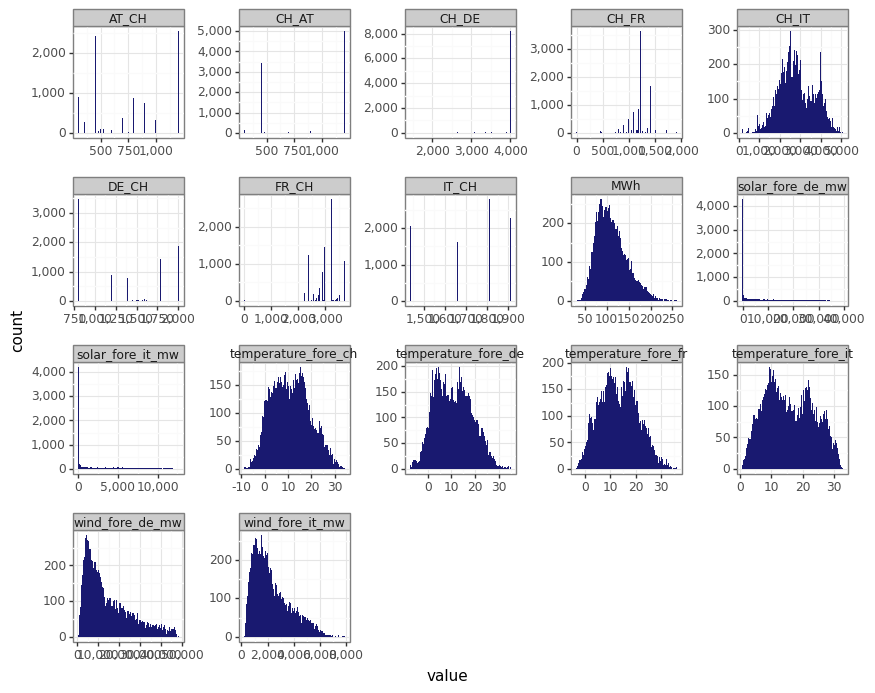

<ggplot: (194868279579)>

In [31]:
(
    ggplot(data=df.select_dtypes(include="number").melt(), mapping=aes(x="value"))
    + geom_histogram(bins=100, fill="midnightblue")
    + facet_wrap("~ variable", scales="free")
    + scale_x_continuous(labels=comma_format())
    + scale_y_continuous(labels=comma_format())
    + theme_bw()
    + theme(figure_size=[10, 8], subplots_adjust={'wspace': 0.5, 'hspace': 0.5})
)

### Additional Feature Generation

- There might be a benefit of encoding cyclical calendar information
- Additionally: Holidays

In [33]:
# Define the country (Switzerland)
country = "CH"

regional_holidays = holidays.CH(
    years=df.datetime.dt.year.unique().tolist()
)

In [34]:
holiday_df = pd.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
)

holiday_df.head()

,holiday_name,holiday_date
0,Neujahrestag,2022-01-01
1,Ostern,2022-04-17
2,Karfreitag,2022-04-15
3,Ostermontag,2022-04-18
4,Auffahrt,2022-05-26


In [35]:
holiday_df.value_counts("holiday_name")

holiday_name
Auffahrt            1
Karfreitag          1
Nationalfeiertag    1
Neujahrestag        1
Ostermontag         1
Ostern              1
Pfingsten           1
Pfingstmontag       1
Weihnachten         1
Name: count, dtype: int64

Might be good to encode those as dummies separately, as these days might have different effects. Let's add those days onto the original dataframe:

In [37]:
df = (
    df.assign(
        hour=lambda x: x.datetime.dt.hour + 1,
        month=lambda x: x.datetime.dt.month,
        quarter=lambda x: x.datetime.dt.quarter,
        wday=lambda x: x.datetime.dt.day_of_week + 1,
        weekend=lambda x: np.where(
            x.datetime.dt.day_name().isin(["Sunday", "Saturday"]), 1, 0
        ).astype(str),
        work_hour=lambda x: np.where(
            x["hour"].isin([19, 20, 21, 22, 23, 24, 0, 1, 2, 3, 4, 5, 6, 7]), 0, 1
        ).astype(str),
        week_hour=lambda x: x.datetime.dt.dayofweek * 24 + (x.datetime.dt.hour + 1),
        year=lambda x: x.datetime.dt.year,
        hour_counter=lambda x: np.arange(0, x.shape[0])
    )
    .assign(day=lambda x: x.datetime.dt.date)
    .merge(holiday_df, how="left", left_on="day", right_on="holiday_date")
    .drop(["holiday_date", "day"], axis=1)
    .assign(holiday_name = lambda x: np.where(x["holiday_name"].isna(), "none", x["holiday_name"]))
)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8764 entries, 0 to 8763
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             8764 non-null   datetime64[ns]
 1   MWh                  8764 non-null   float64       
 2   temperature_fore_ch  8764 non-null   float64       
 3   temperature_fore_fr  8764 non-null   float64       
 4   temperature_fore_de  8764 non-null   float64       
 5   temperature_fore_it  8764 non-null   float64       
 6   solar_fore_de_mw     8763 non-null   float64       
 7   solar_fore_it_mw     8763 non-null   float64       
 8   wind_fore_de_mw      8763 non-null   float64       
 9   wind_fore_it_mw      8763 non-null   float64       
 10  CH_AT                8763 non-null   float64       
 11  CH_DE                8763 non-null   float64       
 12  CH_FR                8763 non-null   float64       
 13  CH_IT                8763 non-nul

In [39]:
df.value_counts("holiday_name")

holiday_name
none                8548
Auffahrt              24
Karfreitag            24
Nationalfeiertag      24
Neujahrestag          24
Ostermontag           24
Ostern                24
Pfingsten             24
Pfingstmontag         24
Weihnachten           24
Name: count, dtype: int64

Those are a few additional features that I can use for prediction-making, which surely hold some additional information. Next, let's decide what happens with which feature.

### Feature Engineering

Other:
- `datetime`: drop, can't feed into net

Numerical:
- everything but `holiday_name`

Categorical
- `holiday_name`: one-hot encode

#### Cyclical Encoding

- avoid issue with exploding feature space when one-hot encoding hundreds of levels in categorical vars
- puts end of cycle closer to beginning (End of Year is not that different from BOY)

In [40]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [41]:
# hour in day
df["hour_sin"] = sin_transformer(24).fit_transform(df["hour"].astype(float))
df["hour_cos"] = cos_transformer(24).fit_transform(df["hour"].astype(float))

# hour in week
df["week_hour_sin"] = sin_transformer(168).fit_transform(df["week_hour"].astype(float))
df["week_hour_cos"] = cos_transformer(168).fit_transform(df["week_hour"].astype(float))

# month
df["month_sin"] = sin_transformer(12).fit_transform(df["month"].astype(float))
df["month_cos"] = cos_transformer(12).fit_transform(df["month"].astype(float))

# quarter
df["quarter_sin"] = sin_transformer(4).fit_transform(df["quarter"].astype(float))
df["quarter_cos"] = cos_transformer(4).fit_transform(df["quarter"].astype(float))

# weekday
df["wday_sin"] = sin_transformer(7).fit_transform(df["wday"].astype(float))
df["wday_cos"] = cos_transformer(7).fit_transform(df["wday"].astype(float))

df = df.drop(["hour", "month", "quarter", "wday", "week_hour"], axis=1)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8764 entries, 0 to 8763
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             8764 non-null   datetime64[ns]
 1   MWh                  8764 non-null   float64       
 2   temperature_fore_ch  8764 non-null   float64       
 3   temperature_fore_fr  8764 non-null   float64       
 4   temperature_fore_de  8764 non-null   float64       
 5   temperature_fore_it  8764 non-null   float64       
 6   solar_fore_de_mw     8763 non-null   float64       
 7   solar_fore_it_mw     8763 non-null   float64       
 8   wind_fore_de_mw      8763 non-null   float64       
 9   wind_fore_it_mw      8763 non-null   float64       
 10  CH_AT                8763 non-null   float64       
 11  CH_DE                8763 non-null   float64       
 12  CH_FR                8763 non-null   float64       
 13  CH_IT                8763 non-nul

### Include target lags

... due to autocorrelation (as description said, I'll believe it).

In [43]:
days = df["datetime"].tolist()

In [44]:
df = df.assign(date = lambda x: x.datetime.dt.date.astype(str))

In [45]:
prior_cutoff = (days[23] - pd.Timedelta("1 day")).strftime('%Y-%m-%d')
f"{prior_cutoff} 23:00"

'2021-12-31 23:00'

In [46]:
lag_lists = []

for day_idx, day in enumerate(tqdm(days)):
    prior_cutoff = (day - pd.Timedelta("1 day")).strftime('%Y-%m-%d')

    lags = df.query("date <= @prior_cutoff").tail(168)["MWh"].tolist()
    lag_lists.append(lags)

  0%|          | 0/8764 [00:00<?, ?it/s]

In [47]:
lag_df = pd.DataFrame(lag_lists).add_prefix("target_lag_")

In [48]:
df = pd.concat([df.drop("date", axis=1), lag_df], axis=1)

#### `sklearn` Pipeline for Data Preparation

In [ ]:
manual_cols = []

pipeline_cols = [col for col in df.drop(["datetime", "MWh"], axis=1).columns if col not in manual_cols]

num_cols = df.drop(["datetime", "MWh"], axis=1).filter(pipeline_cols).select_dtypes(include=np.number).columns
cat_cols = df.drop(["datetime", "MWh"], axis=1).filter(pipeline_cols).select_dtypes(exclude=np.number).columns

In [196]:
pipeline_cols

['temperature_fore_ch',
 'temperature_fore_fr',
 'temperature_fore_de',
 'temperature_fore_it',
 'solar_fore_de_mw',
 'solar_fore_it_mw',
 'wind_fore_de_mw',
 'wind_fore_it_mw',
 'CH_AT',
 'CH_DE',
 'CH_FR',
 'CH_IT',
 'AT_CH',
 'DE_CH',
 'FR_CH',
 'IT_CH',
 'weekend',
 'work_hour',
 'year',
 'hour_counter',
 'holiday_name',
 'hour_sin',
 'hour_cos',
 'week_hour_sin',
 'week_hour_cos',
 'month_sin',
 'month_cos',
 'quarter_sin',
 'quarter_cos',
 'wday_sin',
 'wday_cos',
 'target_lag_0',
 'target_lag_1',
 'target_lag_2',
 'target_lag_3',
 'target_lag_4',
 'target_lag_5',
 'target_lag_6',
 'target_lag_7',
 'target_lag_8',
 'target_lag_9',
 'target_lag_10',
 'target_lag_11',
 'target_lag_12',
 'target_lag_13',
 'target_lag_14',
 'target_lag_15',
 'target_lag_16',
 'target_lag_17',
 'target_lag_18',
 'target_lag_19',
 'target_lag_20',
 'target_lag_21',
 'target_lag_22',
 'target_lag_23',
 'target_lag_24',
 'target_lag_25',
 'target_lag_26',
 'target_lag_27',
 'target_lag_28',
 'target_lag_

In [197]:
num_cols

Index(['temperature_fore_ch', 'temperature_fore_fr', 'temperature_fore_de',
       'temperature_fore_it', 'solar_fore_de_mw', 'solar_fore_it_mw',
       'wind_fore_de_mw', 'wind_fore_it_mw', 'CH_AT', 'CH_DE',
       ...
       'target_lag_158', 'target_lag_159', 'target_lag_160', 'target_lag_161',
       'target_lag_162', 'target_lag_163', 'target_lag_164', 'target_lag_165',
       'target_lag_166', 'target_lag_167'],
      dtype='object', length=196)

In [198]:
cat_cols

Index(['weekend', 'work_hour', 'holiday_name'], dtype='object')

In [199]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

# Making column transformer where all transformers in the pipelines are included
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

### Saving Preprocessing Pipeline and Clean Training Data

Let's first move temperatur and globalstrahlung to the beginning of the dataframe in order to keep consistency after left-joining the dirty data for the test period later:

In [49]:
# Define the two columns to be moved to the beginning
columns_to_move = ["datetime", "MWh"]

# Create a new DataFrame with the desired column order
df = df[columns_to_move + [col for col in df.columns if col not in columns_to_move]]

df.head()

,datetime,MWh,temperature_fore_ch,temperature_fore_fr,temperature_fore_de,temperature_fore_it,solar_fore_de_mw,solar_fore_it_mw,wind_fore_de_mw,wind_fore_it_mw,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH,weekend,work_hour,year,hour_counter,holiday_name,hour_sin,hour_cos,...,target_lag_143,target_lag_144,target_lag_145,target_lag_146,target_lag_147,target_lag_148,target_lag_149,target_lag_150,target_lag_151,target_lag_152,target_lag_153,target_lag_154,target_lag_155,target_lag_156,target_lag_157,target_lag_158,target_lag_159,target_lag_160,target_lag_161,target_lag_162,target_lag_163,target_lag_164,target_lag_165,target_lag_166,target_lag_167
0,2022-01-01 00:00:00,146.054792,6.77,8.31,10.64,7.25,0.0,0.0,31805.65,1331.48,1200.0,4000.0,1400.0,3158.0,1200.0,800.0,3200.0,1910.0,1,0,2022,0,Neujahrestag,0.258819,0.965926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 01:00:00,139.133354,6.42,8.01,10.46,7.09,0.0,0.0,29880.67,1438.15,1200.0,4000.0,1400.0,3213.0,1200.0,800.0,3200.0,1910.0,1,0,2022,1,Neujahrestag,0.500000,0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01 02:00:00,147.562500,6.08,7.77,10.21,6.94,0.0,0.0,28826.75,1623.80,1200.0,4000.0,1400.0,2824.0,1200.0,800.0,3200.0,1910.0,1,0,2022,2,Neujahrestag,0.707107,0.707107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01 03:00:00,157.636204,5.68,7.62,10.07,6.85,0.0,0.0,27631.75,1894.75,1200.0,4000.0,1400.0,2678.0,1200.0,800.0,3200.0,1910.0,1,0,2022,3,Neujahrestag,0.866025,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01 04:00:00,163.326766,5.32,7.39,9.87,6.65,0.0,0.0,27128.00,2335.05,1200.0,4000.0,1400.0,2629.0,1200.0,800.0,3200.0,1910.0,1,0,2022,4,Neujahrestag,0.965926,0.258819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df.assign(duplicated = lambda x: x.datetime.duplicated())

,datetime,MWh,temperature_fore_ch,temperature_fore_fr,temperature_fore_de,temperature_fore_it,solar_fore_de_mw,solar_fore_it_mw,wind_fore_de_mw,wind_fore_it_mw,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH,weekend,work_hour,year,hour_counter,holiday_name,hour_sin,hour_cos,...,target_lag_144,target_lag_145,target_lag_146,target_lag_147,target_lag_148,target_lag_149,target_lag_150,target_lag_151,target_lag_152,target_lag_153,target_lag_154,target_lag_155,target_lag_156,target_lag_157,target_lag_158,target_lag_159,target_lag_160,target_lag_161,target_lag_162,target_lag_163,target_lag_164,target_lag_165,target_lag_166,target_lag_167,duplicated
0,2022-01-01 00:00:00,146.054792,6.77,8.31,10.64,7.25,0.0,0.0,31805.65,1331.48,1200.0,4000.0,1400.0,3158.0,1200.0,800.0,3200.0,1910.0,1,0,2022,0,Neujahrestag,2.588190e-01,0.965926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2022-01-01 01:00:00,139.133354,6.42,8.01,10.46,7.09,0.0,0.0,29880.67,1438.15,1200.0,4000.0,1400.0,3213.0,1200.0,800.0,3200.0,1910.0,1,0,2022,1,Neujahrestag,5.000000e-01,0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2022-01-01 02:00:00,147.562500,6.08,7.77,10.21,6.94,0.0,0.0,28826.75,1623.80,1200.0,4000.0,1400.0,2824.0,1200.0,800.0,3200.0,1910.0,1,0,2022,2,Neujahrestag,7.071068e-01,0.707107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2022-01-01 03:00:00,157.636204,5.68,7.62,10.07,6.85,0.0,0.0,27631.75,1894.75,1200.0,4000.0,1400.0,2678.0,1200.0,800.0,3200.0,1910.0,1,0,2022,3,Neujahrestag,8.660254e-01,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2022-01-01 04:00:00,163.326766,5.32,7.39,9.87,6.65,0.0,0.0,27128.00,2335.05,1200.0,4000.0,1400.0,2629.0,1200.0,800.0,3200.0,1910.0,1,0,2022,4,Neujahrestag,9.659258e-01,0.258819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8759,2022-12-31 19:00:00,67.876028,9.67,13.90,13.91,10.76,0.0,0.0,44107.32,569.68,1200.0,4000.0,1200.0,1507.0,1000.0,800.0,3700.0,1810.0,1,0,2022,8759,none,-8.660254e-01,0.500000,...,142.919117,156.773506,143.824683,143.573879,140.957663,129.295384,124.736827,129.098016,114.592201,113.904337,110.687652,111.462452,110.015173,108.929387,125.451378,137.622234,135.428116,132.88221,130.426565,123.749551,149.211205,150.515579,197.461151,185.654299,False
8760,2022-12-31 20:00:00,72.765318,9.10,13.57,13.79,10.06,0.0,0.0,44512.60,459.45,1200.0,4000.0,1200.0,1507.0,1000.0,800.0,3700.0,1810.0,1,0,2022,8760,none,-7.071068e-01,0.707107,...,142.919117,156.773506,143.824683,143.573879,140.957663,129.295384,124.736827,129.098016,114.592201,113.904337,110.687652,111.462452,110.015173,108.929387,125.451378,137.622234,135.428116,132.88221,130.426565,123.749551,149.211205,150.515579,197.461151,185.654299,False
8761,2022-12-31 21:00:00,81.277633,8.64,13.29,13.64,9.61,0.0,0.0,44946.45,399.35,1200.0,4000.0,1200.0,1507.0,1000.0,800.0,3700.0,1810.0,1,0,2022,8761,none,-5.000000e-01,0.866025,...,142.919117,156.773506,143.824683,143.573879,140.957663,129.295384,124.736827,129.098016,114.592201,113.904337,110.687652,111.462452,110.015173,108.929387,125.451378,137.622234,135.428116,132.88221,130.426565,123.749551,149.211205,150.515579,197.461151,185.654299,False
8762,2022-12-31 22:00:00,95.496046,8.25,13.20,13.61,9.21,0.0,0.0,44938.83,420.78,1200.0,4000.0,1200.0,1459.0,1000.0,800.0,3700.0,1810.0,1,0,2022,8762,none,-2.588190e-01,0.965926,...,142.919117,156.773506,143.824683,143.573879,140.957663,129.295384,124.736827,129.098016,114.592201,113.904337,110.687652,111.462452,110.015173,108.929387,125.451378,137.622234,

In [201]:
from pickle import dump, load

Saving the sklearn pipeline on the training dataset:

In [202]:
dump(preprocessor, open('Models/sklearn_base_pipeline_unfitted.pickle', 'wb'))

Saving the preprocessed dataframe in order to get back to the timestamps:

In [52]:
df.to_csv("Preprocessed Data/df_test_preprocessed.csv", index=False)